In [7]:
import re
import emot
import nltk
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

In [8]:
def replace_emoji(text):
    emot_obj = emot.core.emot()
    emotes = emot_obj.emoji(text)
    for i in range(len(emotes['value'])):
        text = text.replace(emotes['value'][i], emotes['mean'][i])
    return text


def normalize(text):
    link_pattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    text = re.sub(link_pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = replace_emoji(text)
    return text


In [9]:
data = pd.read_csv("twitter-scraper/scraped_tweets_missingbaby.csv")
tweets = data['text']
print(normalize(tweets[255]))



my heart is broken reading what has happened to Constance Marten's baby after meeting them whilst they were on the run - abit more shaken up as i'd thought. RIP little angel, you are safe now:dove:️:cloud:️


In [10]:
analyzer = SentimentIntensityAnalyzer()

# Define a dictionary to map the sentiment scores to emotions
emotion_dict = {}

all_scores = []

# Loop through each tweet and determine the emotion
for tweet in tweets:
    # Get the sentiment score for the tweet
    sentiment_score = analyzer.polarity_scores(normalize(tweet))
    all_scores.append(sentiment_score)
    # Determine the emotion based on the sentiment score
    
    if sentiment_score['neg'] > sentiment_score['pos']:
        if sentiment_score['neg'] > sentiment_score['neu']:
            emotion_dict['anger'] += 1
        else:
            emotion_dict['upset'] += 1
            
            
    elif sentiment_score['pos'] > sentiment_score['neg']:
        if sentiment_score['pos'] > sentiment_score['neu']:
            emotion_dict['happiness'] += 1
        else:
            emotion_dict['shocked'] += 1
            
            
    else:
        if sentiment_score['neu'] > 0.5:
            emotion_dict['nutural'] += 1
        else:
            emotion_dict['sadness'] += 1

In [11]:
# Print the count of each emotion
for emotion, count in emotion_dict.items():
    print(f"{emotion}: {count}")

anger: 131
confusion: 8368
sadness: 0
depression: 0
happiness: 16
amazement: 1286
shock: 0


In [12]:
all_scores 

[{'neg': 0.096, 'neu': 0.904, 'pos': 0.0, 'compound': -0.2023},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.13, 'neu': 0.785, 'pos': 0.085, 'compound': -0.3612},
 {'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'compound': -0.7845},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.243, 'neu': 0.671, 'pos': 0.086, 'compound': -0.8707},
 {'neg': 0.243, 'neu': 0.671, 'pos': 0.086, 'compound': -0.8707},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.158, 'neu': 0.633, 'pos': 0.209, 'compound': 0.2023},
 {'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'compound': 0.6249},
 {'neg': 0.363, 'neu': 0.637, 'pos': 0.0, 'compound': -0.6908},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994},
 {'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'compound': 0.6249},
 {'neg': 0.118, 'neu': 0.882, 'pos': 0.0, 'compound': -0.34},
 {'neg': 0.0, 

In [13]:
cc = []
for i in all_scores:
    cc.append(i['compound'])

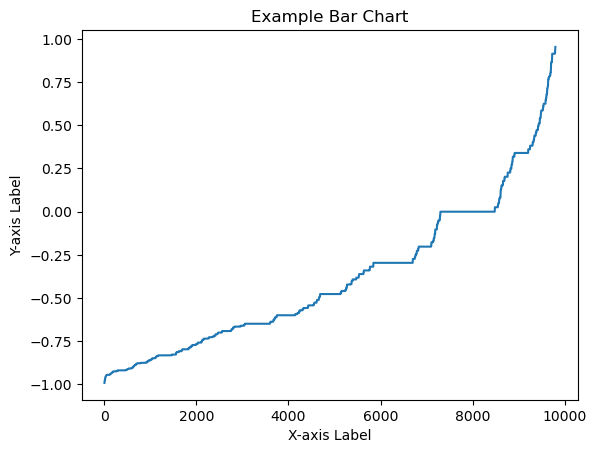

In [20]:
import matplotlib.pyplot as plt
x = range(0,len(cc))
plt.plot(x, sorted(cc))

# Set the chart title and axis labels
plt.title('Example Bar Chart')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# Display the chart
plt.show()

In [30]:
for tweet in tweets:
    print(tweet,' : ',analyzer.polarity_scores(tweet))
    print()

Runaway British Mum, Constance Marten, Charged With Manslaughter, Was 'Groomed By Nigerian Sect Leader, TB Joshua’ | Sahara Reporters https://t.co/HeYJpBXRDG https://t.co/yhSh2DcHRQ  :  {'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'compound': -0.2023}

Detectives continue to quiz Constance Marten and Mark Gordon after the remains of a baby were found https://t.co/Owe28jjNsi  :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Constance Marten and Mark Gordon blow each other a kiss in dock before court hears dead baby was found in bag in shed | UK News | Mon | 6 Mar | 13:15 | UTC https://t.co/dBXCD17QhT  :  {'neg': 0.126, 'neu': 0.792, 'pos': 0.082, 'compound': -0.3612}

Constance Marten and Mark Gordon named baby before tragic infant’s death, court told as couple remanded in custody | UK News | Mon | 6 Mar | 13:14 | UTC https://t.co/LPU1AsDe87  :  {'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'compound': -0.7845}

Lewis Power KC and @colinwitcher instructed on behalf of Constance Marten



@MaizyDaizyZzzz Nothing is ever "leaked" unless it's meant to be. Link with Nicola Bulley &amp; Constance Marten stories....police wanted to ensure no "online speculation" among the public as to what happened. Certainly a path to end free speech. #problemreactionsolution  :  {'neg': 0.049, 'neu': 0.764, 'pos': 0.187, 'compound': 0.7269}

Runaway mum Constance Marten was 'groomed' by evil Nigerian sect leader https://t.co/QamAppTlMr  :  {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.6597}

Constance Marten (35) and Mark Gordon (48) went missing with their new born baby after their car broke down on #M61 (near junction 4) #Farnworh (#Bolton) (#GreaterManchester) on January 5, 2023
https://t.co/ifWjfIdFyA  :  {'neg': 0.143, 'neu': 0.857, 'pos': 0.0, 'compound': -0.6124}

Constance Marten (35) and Mark Gordon (48) went missing with their new born baby after their car broke down on #M61 (near junction 4) #Farnworh (#Bolton) (#GreaterManchester) on January 5, 2023
https://t.co/ifWjf

@GBNEWS The sad thing is they already dumped the baby’s pram before 31st January in Newhaven East Sussex 😔https://t.co/98pJZz0qPo  :  {'neg': 0.254, 'neu': 0.746, 'pos': 0.0, 'compound': -0.7003}

I’m so tired of seeing muppets crying &amp; acting a fool over a dead baby when they do sod all to help vulnerable, abused babies &amp; people who are actually alive. What a farce! Constance Marten case 
Shove your vigil candles up your bum  :  {'neg': 0.368, 'neu': 0.543, 'pos': 0.09, 'compound': -0.9467}

Constance Marten &amp; Mark Gordon will next appear at the Old Bailey on 31 March.

We can now confirm the baby was a girl &amp; had been named Victoria.

There should be no reporting or commentary which could in any way prejudice active criminal proceedings.

https://t.co/gMx8zcCusx  :  {'neg': 0.169, 'neu': 0.779, 'pos': 0.051, 'compound': -0.7351}

Constance Marten and Mark Gordon Remanded on Manslaughter Charge of Baby Girl
https://t.co/xzZK36mlUa https://t.co/uHftthNqQC  :  {'neg': 0.

I am going to be honest, I struggled to read this. I suggest a murder charge, all round - surely? ‼️‼️‼️⁉️

https://t.co/xDirOeM3qx
Constance Marten and Mark Gordon charged with gross negligence manslaughter after baby's remains found in Brighton https://t.co/FJoOHaBhY5  :  {'neg': 0.26, 'neu': 0.606, 'pos': 0.134, 'compound': -0.7003}

"We believe sadly the baby may have been dead for some time" 

Police questioning Constance Marten and Mark Gordon say it is too early to give a date on the baby's death 

https://t.co/3w3agWMrgd https://t.co/RWUNYzLAHh  :  {'neg': 0.3, 'neu': 0.7, 'pos': 0.0, 'compound': -0.9081}

Constance Marten and Mark Gordon charged with gross negligence manslaughter - BBC News
Time for you to suffer 🤬🤬 https://t.co/WaM5uGA1Z0  :  {'neg': 0.344, 'neu': 0.656, 'pos': 0.0, 'compound': -0.8126}

Constance Marten in court live alongside Mark Gordon after baby body found https://t.co/eyozOtNgLE  :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Detectives from 

BREAKING NEWS; A Couple; Constance Marten 35yrs &amp; Mark Gordon 48yrs have tonight been charged with Gross Negligence Manslaughter &amp; concealing the birth of a child &amp; perverting the course of justice; relating to remains of a baby found in Sussex yesterday; AG Guidelines now apply!  :  {'neg': 0.145, 'neu': 0.786, 'pos': 0.069, 'compound': -0.4199}

Constance Marten and Mark Gordon charged with gross negligence manslaughter - BBC News https://t.co/MPw7RZdCWV  :  {'neg': 0.308, 'neu': 0.692, 'pos': 0.0, 'compound': -0.5994}

Erm I'm not being funny but how can they do this in 48 hours when it took  Lancashire police 3 weeks to find Nicola Bulley. Why weren't they searching a wider area? 

BBC News - Constance Marten arrest: Police continue questioning after baby found
https://t.co/MiNLDYDeqH  :  {'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'compound': -0.6601}

BREAKING NEWS; A Couple; Constance Marten 35yrs &amp; Mark Gordon 48yrs have tonight been charged with Gross Negligence M

"We believe sadly the baby may have been dead for some time" 

Police questioning Constance Marten and Mark Gordon say it is too early to give a date on the baby's death 

https://t.co/3w3agWMrgd https://t.co/RWUNYzLAHh  :  {'neg': 0.3, 'neu': 0.7, 'pos': 0.0, 'compound': -0.9081}

The media assumes that privileged aristocrats are good people — leaving the tabloids asking — “what went wrong with Constance Marten?”

Yet no one would ask how a working class woman turned into a bad un. 

Class privilege doesn’t make someone a better person. https://t.co/p9J17Yd7RQ  :  {'neg': 0.166, 'neu': 0.623, 'pos': 0.211, 'compound': 0.34}

Police questioning Constance Marten and Mark Gordon say they believe the baby whose remains were found in woodland may have been dead "for some time”. 

They haven’t yet been able to confirm the baby’s gender.  :  {'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'compound': -0.6908}

The death of Constance Marten's baby is heartbreaking.
The 'fallen aristo' arc is in full

Post-mortem on Constance Marten’s baby to be held as parents face more police questioning https://t.co/nyQqK52IrW  :  {'neg': 0.107, 'neu': 0.893, 'pos': 0.0, 'compound': -0.1725}

The remains of Constance Marten’s missing baby have been found, police have confirmed. It comes after a desperate search involving more than 200 officers since she and her boyfriend Mark Gordon were found and arrested on Monday night in Brighton.  :  {'neg': 0.174, 'neu': 0.826, 'pos': 0.0, 'compound': -0.765}

The body of a baby was found close to where a British aristocrat and her partner were arrested over concerns for their child's welfare, UK police say https://t.co/PUbFefNebP  :  {'neg': 0.11, 'neu': 0.89, 'pos': 0.0, 'compound': -0.4767}

Erm I'm not being funny but how can they do this in 48 hours when it took  Lancashire police 3 weeks to find Nicola Bulley. Why weren't they searching a wider area? 

BBC News - Constance Marten arrest: Police continue questioning after baby found
https://t.co/MiNLDY

For those asking why the police were 'chasing' Constance Marten &amp; her baby. A thread...
When a drug abusing mother &amp; a sex offending, abusive partner  have a child, social services have a duty of care &amp; will  monitor the child closely 1  :  {'neg': 0.225, 'neu': 0.707, 'pos': 0.069, 'compound': -0.8074}

Baby's body found by UK police searching for missing child of Constance Marten and Mark Gordon https://t.co/U8KcUL8Q6l  :  {'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.296}

Remains of baby found in wooded area where Constance and Mark were arrested.
 Reading Time: 2 minutesThe remains of a baby have been discovered in a wooded area near where Constance Marten and Mark Gorden were arrested in Brighton, police said on Wednes https://t.co/G3p2yhF0IQ https://t.co/3oeXrbVRmA  :  {'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'compound': -0.7351}

Police holding aristocrat Constance Marten find the body of a baby 
So sad. It seems from the article that she was more concerne

Constance Marten and Mark Gordon…
Fuck you. Fuck you both. Rot in hell and be thoroughly miserable for all eternity.  :  {'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'compound': -0.9441}

Missing aristocrat Constance Marten &amp; lover Mark Gordon arrested but baby STILL missing &amp; may have been left out in open | UK News | Wed | 1 Mar | 21:13 | UTC https://t.co/icv1zQyB4V  :  {'neg': 0.196, 'neu': 0.731, 'pos': 0.073, 'compound': -0.4678}

Police confirm aristocrat Constance Marten’s baby has died: Body of newborn is found https://t.co/pC598A8BQZ https://t.co/1rrFpYUOWk  :  {'neg': 0.205, 'neu': 0.795, 'pos': 0.0, 'compound': -0.5574}

Constance Marten police give major update on search for baby and reveal fears after temperature plunged to 1C overnight | UK News | Wed | 1 Mar | 21:13 | UTC https://t.co/8etij0KmQ5  :  {'neg': 0.101, 'neu': 0.899, 'pos': 0.0, 'compound': -0.4215}

Police searching for Constance Marten's missing baby find infant's remains
https://t.co/Qu3DjjsfCH  :  {'ne

Police holding aristocrat Constance Marten find the body of a baby
Why didn’t they leave the dear baby at a hospital or somewhere that it would have been safe. They need stringing up and they’d be a long line of people to do it!! Devastating!!❤️🙏 https://t.co/ABJSLUb99o  :  {'neg': 0.025, 'neu': 0.836, 'pos': 0.139, 'compound': 0.7556}

Baby's body found by UK police searching for missing child of Constance Marten and Mark Gordon https://t.co/U8KcUL8Q6l  :  {'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.296}

BREAKING: Police have found the remains of a baby during the search for a missing child

Parents Constance Marten and Mark Gordon were arrested in Brighton this week on suspicion of child neglect and gross negligence manslaughter

https://t.co/hyqsQHg5qd

📺 Sky 501 and YouTube https://t.co/5ax1S3qQLz  :  {'neg': 0.28, 'neu': 0.72, 'pos': 0.0, 'compound': -0.9186}

This world is a fucking cesspit.
Constance Marten and Mark Gordon should be hanged .

I'm honestly lost for w

#Breaking Remains have been found in the search for the two-month-old baby of Constance Marten and Mark Gordon, Detective Superintendent Lewis Basford of the Metropolitan Police said https://t.co/rbfKATWFdI  :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Constance Marten and Mark Gordon's baby found dead after manhunt https://t.co/Ul4gfM2jtr  :  {'neg': 0.301, 'neu': 0.699, 'pos': 0.0, 'compound': -0.6486}

I pray tonight for the baby of "Constance Marten”. Absolutely heartbreaking. Rest with the angels now  :  {'neg': 0.177, 'neu': 0.699, 'pos': 0.124, 'compound': -0.2484}

News no one wants to hear. 

@metpoliceuk and @sussex_police have said that officers discovered the remains of a baby this afternoon, near where Constance Marten and Mark Gordon were arrested.  :  {'neg': 0.164, 'neu': 0.836, 'pos': 0.0, 'compound': -0.6486}

Police searching for Constance Marten's missing baby find infant's remains
https://t.co/Qu3DjjsfCH  :  {'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'comp

Frantic police search for runaway aristocrat Constance Marten's's missing baby enters its second day - https://t.co/mOZijLxJW5  :  {'neg': 0.282, 'neu': 0.718, 'pos': 0.0, 'compound': -0.6249}

Constance Marten and her partner Mark Gordon have been arrested in Brighton but the baby was not with them.
Where is the baby?
Dear God I hope the baby is OK ❤️🙏🏾
https://t.co/rnbNUJ9JeT  :  {'neg': 0.048, 'neu': 0.63, 'pos': 0.322, 'compound': 0.9144}

Constance Marten baby updates — Police presence ramps up as search for missing infant ‘may not end as they’d like’ | Politics News | Wed | 1 Mar | 10:30 | UTC https://t.co/5SLGHcZJka  :  {'neg': 0.081, 'neu': 0.919, 'pos': 0.0, 'compound': -0.296}

BBC News - Constance Marten and Mark Gordon arrest: Search for baby continues
https://t.co/V05p7FsJsQ  :  {'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.34}

The areas in Brighton currently being searched as Constance Marten's baby is still missing.

https://t.co/gUOL9EuFYW  :  {'neg': 0.136, 

Keep your eyes open people! The signs are there in plain sight 👍

Constance Marten and Mark Gordon arrested on suspicion of gross negligence manslaughter | UK news | The Guardian https://t.co/hJ58p5EIvV  :  {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.8439}

“The couple have not given the location of the baby - nor its gender - and are said to be still refusing to cooperate with police”. Missing baby feared dead as police arrest mother and boyfriend. This callousness of this is incomprehensible. 
 https://t.co/cHnV6XjssF  :  {'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'compound': -0.93}

“The couple have not given the location of the baby - nor its gender - and are said to be still refusing to cooperate with police”. Missing baby feared dead as police arrest mother and boyfriend. This callousness of this is incomprehensible. 
 https://t.co/cHnV6XjssF  :  {'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'compound': -0.93}

Constance Marten: The former Tatler It-girl who became estranged

😢I hope they let authorities know where the baby is 😢

BBC News - Constance Marten and Mark Gordon arrested on suspicion of manslaughter
https://t.co/bSHuA864CH  :  {'neg': 0.199, 'neu': 0.699, 'pos': 0.101, 'compound': -0.4215}

Constance Marten and her partner Mark Gordon have been arrested in Brighton but the baby was not with them.
Where is the baby?
Dear God I hope the baby is OK ❤️🙏🏾
https://t.co/rnbNUJ9JeT  :  {'neg': 0.048, 'neu': 0.63, 'pos': 0.322, 'compound': 0.9144}

The Poor Baby 😢😢 https://t.co/SPZNiHKx3F  :  {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767}

Police confirm the £10,000 reward for information leading to the location of Constance Marten's newborn baby "remains open" 

DS Lewis Basford also confirmed investigators are "open-minded" to the hypothesis the baby may be in somebody's care.

https://t.co/F3pUiDH32u

📺 Sky 501 https://t.co/JfMKDfjhuF  :  {'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'compound': 0.7845}

🙏🏼hope they find the missing baby of C

Constance Marten and Mark Gordon further arrested on suspicion of gross negligence manslaughter.

Search for the missing baby continues. 

200+ officers searching 90+ square miles between #Brighton and #Newhaven

☎️ Any info please call 999
@sussex_police

https://t.co/xbJkw4QviM  :  {'neg': 0.243, 'neu': 0.706, 'pos': 0.051, 'compound': -0.8271}

#TeamRPUafo #BreakingNews #trabn: Constance Marten and Mark Gordon arrested on suspicion of gross negligence manslaughter, UK police say https://t.co/pDJjQL8woJ https://t.co/gSk3AnrMeZ  :  {'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'compound': -0.8316}

Constance Marten and partner arrested on suspicion of gross negligence manslaughter https://t.co/gGdFGSigST  :  {'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.8316}

Constance Marten and Mark Gordon arrested for manslaughter https://t.co/oUwP4Z82GP  :  {'neg': 0.279, 'neu': 0.721, 'pos': 0.0, 'compound': -0.4767}

Constance Marten and Mark Gordon further arrested on suspicion of gross n

Update : Constance Marten &amp; Mark Gordon remain in police custody arrested on suspicion of child neglect, and have so far refused to tell police the sex of their baby, or where it is . The baby has had no medical attention since birth. Huge search is now underway to find baby. https://t.co/o56Tm58wCW  :  {'neg': 0.22, 'neu': 0.742, 'pos': 0.038, 'compound': -0.8773}

I hope they throw the book at Constance Marten and her partner for not telling the police where the baby is.  :  {'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'compound': 0.4404}

Missing aristocrat Constance Marten and her partner Mark Gordon are arrested - but their baby is still missing #brighton https://t.co/H9GJHzI1Nh  :  {'neg': 0.287, 'neu': 0.713, 'pos': 0.0, 'compound': -0.6652}

Missing aristocrat Constance Marten and her partner Mark Gordon are arrested - but their baby is still missing #brighton https://t.co/H9GJHzI1Nh  :  {'neg': 0.287, 'neu': 0.713, 'pos': 0.0, 'compound': -0.6652}

Missing couple arrested in B

'When the couple's car was found abandoned on the M61, there were signs that a day or two before Constance Marten had given birth, either in the car or very near.'

Mark White reports from Brighton with the latest on the search for Constance Marten's missing baby. https://t.co/Bf9EoxSYpI  :  {'neg': 0.104, 'neu': 0.896, 'pos': 0.0, 'compound': -0.6369}

Constance Marten and her partner Mark Gordon are arrested - but their baby is still missing - Sky News - So these two have been on the run for weeks,but the cops haven’t said why they’ve been arrested ? The only dodgy part is this missing baby? Curious!.. https://t.co/3gzzTEWNxp  :  {'neg': 0.27, 'neu': 0.73, 'pos': 0.0, 'compound': -0.93}

“This man is a true, dyed-in-wool psycho and should be hanged for crimes against humanity,” wrote Napier Marten, 63, a former page to Queen Elizabeth II, of Bill Gates on 3 Jan, two days before his daughter Constance’s burning car was found.🥴 https://t.co/ooQNc32nmi  :  {'neg': 0.0, 'neu': 0.933, 'po

Plice have arrested Constance Marten and Mark Gordon without the baby. So now the baby is somewhere alone and the bumbling cops ste looking for it. Surely would have been better to follow then once spotted so they could know where baby is. If baby dies it will be polices fault.  :  {'neg': 0.131, 'neu': 0.772, 'pos': 0.097, 'compound': -0.25}

Constance Marten and boyfriend arrested but newborn still missing - https://t.co/Uhj0duZVhj  :  {'neg': 0.377, 'neu': 0.623, 'pos': 0.0, 'compound': -0.5927}

Constance Marten and boyfriend arrested but newborn still missing - https://t.co/bZVTWgCOma  :  {'neg': 0.377, 'neu': 0.623, 'pos': 0.0, 'compound': -0.5927}

Constance Marten: Lacking aristocrat arrested – however child nonetheless lacking
https://t.co/CMjDmORlAB  :  {'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'compound': -0.4767}

Constance Marten and her partner Mark Gordon have been arrested in Brighton but the baby was not with them.
Where is the baby?
Dear God I hope the baby is OK ❤️🙏🏾
